# Movie Studio Analysis - Westend Productions

## Executive Summary
This analysis examines movie industry data to provide actionable insights for Westend Productions' strategic decision-making. By analyzing financial performance, genre profitability, budget optimization, and audience reception, we've identified key opportunities to maximize return on investment in film production.

## 1. Business Understanding

### Business Problem

Westend Productions needs to make data-driven decisions about what types of movies to produce to maximize profitability and market success in a competitive industry.

**Objectives:**  
1. To identify the most and least profitable genres.  
2. To compare profitability of older (≤2010) vs newer (>2010) films.  
3. To determine whether higher IMDb ratings has a relationship with ROI.  
4. To understand budget levels across genres.  
5. To prepare data for predictive modeling (linear regression).  

**Stakeholders:**

1. Staff (Writers, Directors, Marketers) - Understand what projects to pursue
2. Management (Executives at Westend) - Use ROI insights to plan investments
3. Kenya Film Classification Board (KFCB) - This is the regulator established under the Act of Parliament Cap 222 Films and Stage plays
4. MSCK (Music Copyright Society of Kenya) - Forecast royalties from popular movies

**Business Questions We Will Answer:**

1. Which genres are most profitable in absolute terms?
2. Which genres provide the best ROI (efficiency)?
3. Do newer films outperform older films financially?
4. Is there a relationship between IMDb ratings and financial success?
5. What is the optimal budget range for different genres?


## 2. Data Understanding

**Raw Data Sources**

We analyzed three different datasets, each providing a unique perspective on the movie industry:

1. **Dataset 1: Movie Budgets Dataset (The Numbers)**

Columns: movie, production_budget, domestic_gross, worldwide_gross, release_date
Purpose: Financial information (costs and revenues)
Challenge: Financial data stored as text with $ signs and commas

2. **Dataset 2: Box Office Mojo (BOM) Dataset**

Columns: movie, domestic_gross, foreign_gross
Purpose: Additional revenue data, especially international
Challenge: Needed to merge without duplicating movies

3. **Dataset 3: IMDb Ratings Dataset**

Columns: movie, start_year, averagerating, numvotes
Purpose: Audience feedback and popularity metrics
Challenge: Multiple rows per movie, inconsistent naming formats

**Why These Datasets Matter:**

Budgets + Grosses - Profitability (business perspective: did the movie make or lose money?)
Ratings - Quality (audience perspective: do people like the movie?)
Year + Genres - Trends (historical/creative perspective: which genres succeed in different eras?)
---

### Why These Raw Datasets Matter

- **Budgets + Grosses → Profitability** (business perspective: did the movie make or lose money?)
- **Ratings → Popularity** (audience perspective: do people like the movie?)
- **Year + Genres → Trends** (historical/creative perspective: which genres succeed in different eras?)


# 3. Data Loading and Initial Exploration

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import textwrap
import os
import seaborn as sns

# Load BOM dataset
bom = pd.read_csv("bom.movie_gross.csv.gz")
print("BOM shape:", bom.shape)
display(bom.head())

# Load The Numbers dataset
tn = pd.read_csv("tn.movie_budgets.csv.gz")
print("TN shape:", tn.shape)
display(tn.head())

# Connect to IMDb SQLite
conn = sqlite3.connect("im.db")

# Preview tables
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables in IMDb DB:")
display(tables)

# Load movie_basics and movie_ratings
basics = pd.read_sql("SELECT * FROM movie_basics;", conn)
ratings = pd.read_sql("SELECT * FROM movie_ratings;", conn)

print("IMDb basics shape:", basics.shape)
print("IMDb ratings shape:", ratings.shape)
display(basics.head())
display(ratings.head())


BOM shape: (3387, 5)


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


TN shape: (5782, 6)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


Tables in IMDb DB:


,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


IMDb basics shape: (146144, 6)
IMDb ratings shape: (73856, 3)


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


## Initial Data Assessment:

Key Findings from Data Exploration:

**BOM Dataset**: 3,387 movies - focus on commercially successful films

**TN Dataset**: 5,782 movies - comprehensive financial data but stored as text

**IMDb Dataset**: 146,144 movies - much larger scope, includes ratings

**Business Insight**: The scale mismatch (IMDb: 146k vs TN/BOM: 3k-6k movies) indicates we're focusing on commercially successful, widely released films with verified financial data - exactly what we need for business decision-making.

# 4. Data Cleaning and Merging


In [2]:
# 1. CLEAN TN DATA 
# make a copy of the original df
tn_clean = tn.copy()

# Remove $ and , then convert to float (to avoid OverflowError)
for col in ["production_budget", "domestic_gross", "worldwide_gross"]:
    tn_clean[col] = (
        tn_clean[col]
        .replace('[\$,]', '', regex=True)
        .replace('', np.nan)
        .astype(float)
    )

# Convert release_date -> datetime, extract year
tn_clean["release_date"] = pd.to_datetime(tn_clean["release_date"], errors="coerce")
tn_clean["year"] = tn_clean["release_date"].dt.year

# Normalize title for merging
tn_clean["title_norm"] = tn_clean["movie"].str.lower().str.replace(r"[^a-z0-9 ]", "", regex=True)

## 4.1 Cleaning The Numbers(TN) Dataset

**Problems Identified:**

1. Financial columns stored as text (e.g., "$425,000,000")

2. Date format inconsistency ("Dec 18, 2009" strings)

3. Movie titles in different formats for merging

Cleaning Strategy:
 
tn_clean = tn.copy()

for col in ["production_budget", "domestic_gross", "worldwide_gross"]:
    tn_clean[col] = (
        tn_clean[col]
        .replace('[\$,]', '', regex=True)
        .replace('', np.nan)
        .astype(float)
    )

What This Code Does:

1: Creates a copy to preserve raw data
2: For each financial column:

Removes $ and commas using regex pattern [\$,]
Handles empty strings by converting to NaN
Converts to float for mathematical operations



Example Transformation:

Input: "$425,000,000"
After regex: "425000000"
After float conversion: 425000000.0

## Data Processing

Convert release_date -> datetime, extract year:

tn_clean["release_date"] = pd.to_datetime(tn_clean["release_date"], errors="coerce")
tn_clean["year"] = tn_clean["release_date"].dt.year

## Title Normalization for Merging

Normalize title for merging:

tn_clean["title_norm"] = tn_clean["movie"].str.lower().str.replace(r"[^a-z0-9 ]", "", regex=True)

Why Title Normalization is Critical:

Different datasets store titles differently:

TN: "Pirates of the Caribbean: On Stranger Tides"
BOM: "Pirates of the Caribbean: On stranger tides"
IMDb: "Pirates of the Caribbean: On Stranger Tides"


Solution: Convert all to lowercase and remove punctuation
Result: "pirates of the caribbean on stranger tides"

## 4.2 Cleaning Box Office Mojo (BOM) Dataset

**Key Differences from TN:**

Only financial columns need cleaning (title, studio, year were clean)
Need to calculate worldwide_gross (not provided directly)

CLEAN BOM DATA:

bom_clean = bom.copy()

Clean financial columns:

for col in ["domestic_gross", "foreign_gross"]:
    bom_clean[col] = (
        bom_clean[col]
        .replace('[\$,]', '', regex=True)
        .replace('', np.nan)
        .astype(float)
    )

Calculate worldwide gross:

bom_clean["worldwide_gross"] = bom_clean["domestic_gross"].fillna(0) + bom_clean["foreign_gross"].fillna(0)

**Business Logic for Worldwide Gross:**

Studios care about global performance, not just domestic
A movie making $300M domestic + $700M foreign ($1B total) is more successful than $400M domestic only

.fillna(0) prevents data loss when one component is missing

In [3]:
# 2. CLEAN BOM DATA
bom_clean = bom.copy()

for col in ["domestic_gross", "foreign_gross"]:
    bom_clean[col] = (
        bom_clean[col]
        .replace('[\$,]', '', regex=True)
        .replace('', np.nan)
        .astype(float)
    )

# Add worldwide gross (domestic + foreign)
bom_clean["worldwide_gross"] = bom_clean["domestic_gross"].fillna(0) + bom_clean["foreign_gross"].fillna(0)

# Normalize title for merging
bom_clean["title_norm"] = bom_clean["title"].str.lower().str.replace(r"[^a-z0-9 ]", "", regex=True)


## 4.3 Merging TN + BOM Datasets

MERGE TN + BOM:

merged = pd.merge(
    tn_clean,
    bom_clean[["title_norm", "worldwide_gross", "domestic_gross", "foreign_gross"]],
    on="title_norm",
    how="inner",
    suffixes=("_tn", "_bom")
)

**Merge Strategy Explained:**

1. Inner join: Only keeps movies that exist in both datasets

2. Suffix handling: Resolves column name conflicts (_tn vs _bom)

3. Column selection: Only takes needed BOM columns to avoid redundancy

**Results:**

1. Started with: TN (5,782) + BOM (3,387)

2. Final merged: 1,334 movies (23% of TN, 39% of BOM)

3. Business implication: Focus on high-profile films with verified data from multiple sources

In [4]:
# 3. MERGE TN + BOM
merged = pd.merge(
    tn_clean,
    bom_clean[["title_norm", "worldwide_gross", "domestic_gross", "foreign_gross"]],
    on="title_norm",
    how="inner",
    suffixes=("_tn", "_bom")
)

print("Merged shape:", merged.shape)
display(merged.head())

Merged shape: (1334, 11)


,id,release_date,movie,production_budget,domestic_gross_tn,worldwide_gross_tn,year,title_norm,worldwide_gross_bom,domestic_gross_bom,foreign_gross
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011,pirates of the caribbean on stranger tides,1.045700e+09,241100000.0,804600000.0
1,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015,avengers age of ultron,1.405400e+09,459000000.0,946400000.0
2,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,2018,avengers infinity war,6.788014e+08,678800000.0,1369.5
3,9,2017-11-17,Justice League,300000000.0,229024295.0,6.559452e+08,2017,justice league,6.579000e+08,229000000.0,428900000.0
4,10,2015-11-06,Spectre,300000000.0,200074175.0,8.796209e+08,2015,spectre,8.807000e+08,200100000.0,680600000.0


# 4.4 Feature Engineering - Creating Business Metrics 

In [5]:
# Feature Engineering

# Choose TN as primary (more consistent), fallback to BOM if missing
merged["worldwide_gross"] = merged["worldwide_gross_tn"].fillna(merged["worldwide_gross_bom"])
merged["domestic_gross"] = merged["domestic_gross_tn"].fillna(merged["domestic_gross_bom"])

# Profit = revenue - budget
merged["profit"] = merged["worldwide_gross"] - merged["production_budget"]

# ROI = profit / budget
merged["roi"] = np.where(
    merged["production_budget"] > 0,
    merged["profit"] / merged["production_budget"],
    np.nan
)

# Quick peek
display(merged[["movie", "production_budget", "worldwide_gross", "profit", "roi"]].head(10))


,movie,production_budget,worldwide_gross,profit,roi
0,Pirates of the Caribbean: On Stranger Tides,410600000.0,1.045664e+09,6.350639e+08,1.546673
1,Avengers: Age of Ultron,330600000.0,1.403014e+09,1.072414e+09,3.243841
2,Avengers: Infinity War,300000000.0,2.048134e+09,1.748134e+09,5.827114
3,Justice League,300000000.0,6.559452e+08,3.559452e+08,1.186484
4,Spectre,300000000.0,8.796209e+08,5.796209e+08,1.932070
5,The Dark Knight Rises,275000000.0,1.084439e+09,8.094391e+08,2.943415
6,Solo: A Star Wars Story,275000000.0,3.931513e+08,1.181513e+08,0.429641
7,The Lone Ranger,275000000.0,2.600021e+08,-1.499788e+07,-0.054538
8,John Carter,275000000.0,2.827781e+08,7.778100e+06,0.028284
9,Tangled,260000000.0,5.864772e+08,3.264772e+08,1.255682


## Why TN is Primary:

TN reports worldwide gross as single, direct figure

BOM calculates by adding domestic + foreign (potential for errors)

TN focuses on complete financial data

Key Metrics Created:

Profit = Revenue - Cost (absolute success measure)

ROI = Profit ÷ Investment (efficiency measure)

Example Analysis:

Avatar: $2.351B profit, 553% ROI

The Lone Ranger: -$15M profit, -5.4% ROI

# 5. Adding IMDb Quality Data

## Loading IMDb Database
Why Add IMDb Data:

Current gap: We have financial performance but not quality indicators

Business question: Do higher-rated movies make more money?

Strategic value: Should we prioritize quality or just commercial appeal?

In [6]:
# Reload imdb_basics to include genres
imdb_basics = pd.read_sql("SELECT movie_id, primary_title, start_year, genres FROM movie_basics", conn)

# Then create the normalized title
imdb_basics["title_norm"] = (
    imdb_basics["primary_title"]
    .str.lower()
    .str.replace(r"[^a-z0-9 ]", "", regex=True)
    .str.strip()
)

# Now the merge should work
movies_cleaned = merged.merge(
    imdb_basics[["title_norm", "genres"]],
    on="title_norm",
    how="left"
)

In [7]:
# Load IMDb tables

imdb_ratings = pd.read_sql("SELECT movie_id, averagerating, numvotes FROM movie_ratings", conn)


**Data Selection Strategy:**

movie_id: Primary key for joining
    
primary_title: For matching with financial data
    
averagerating: Quality indicator (1-10 scale)
    
numvotes: Reliability indicator (more votes = more reliable)

## 5.2 Integrating Quality Metrics

In [8]:
# Merge basics + ratings
imdb = imdb_basics.merge(imdb_ratings, on="movie_id", how="inner")

**Data Quality Decisions:**

Drop movies without ratings (can't analyze performance without ratings)

Drop movies without years (essential for time-series analysis)

Better to have fewer complete records than incomplete data causing analysis issues

In [9]:
# Normalize title for merging
imdb["title_norm"] = imdb["primary_title"].str.lower().str.replace(r"[^a-z0-9 ]", "", regex=True)

# Drop missing ratings or year
imdb_clean = imdb.dropna(subset=["start_year", "averagerating"])

# Drop missing ratings or year
imdb_clean = imdb.dropna(subset=["start_year", "averagerating"])

print("IMDb shape:", imdb.shape)
display(imdb_clean.head())

IMDb shape: (73856, 7)


,movie_id,primary_title,start_year,genres,title_norm,averagerating,numvotes
0,tt0063540,Sunghursh,2013,"Action,Crime,Drama",sunghursh,7.0,77
1,tt0066787,One Day Before the Rainy Season,2019,"Biography,Drama",one day before the rainy season,7.2,43
2,tt0069049,The Other Side of the Wind,2018,Drama,the other side of the wind,6.9,4517
3,tt0069204,Sabse Bada Sukh,2018,"Comedy,Drama",sabse bada sukh,6.1,13
4,tt0100275,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy",the wandering soap opera,6.5,119


## 5.3 Final dataset integration

In [10]:
# Merge with TN+BOM merged dataset
merged_rated = pd.merge(
    merged,
    imdb_clean[["title_norm", "start_year", "averagerating", "numvotes"]],
    left_on=["title_norm", "year"],   # use both title + year
    right_on=["title_norm", "start_year"],
    how="left"
)

merged_rated = merged_rated.sort_values("numvotes", ascending=False)
merged_rated = merged_rated.drop_duplicates(subset=["movie", "year"])

print("Merged + Ratings shape:", merged_rated.shape)

Merged + Ratings shape: (1334, 18)


**Final Dataset Features:**

Financial performance: revenue, budget, profit, ROI

Audience reception: IMDb ratings, number of votes

Movie details: title, year, genre

Total movies: 1,334 with complete data

# 6. Exploratory Data Analysis


In [11]:
# Deduplicate merged dataset by collapsing multiple IMDb entries for same movie
movies_cleaned = (
    merged_rated
    .groupby(['movie', 'production_budget', 'worldwide_gross', 'profit', 'roi'], as_index=False)
    .agg({
        'averagerating': 'mean',   # average rating across duplicates
        'numvotes': 'sum'          # add up all votes
    })
)

print("After deduplication:")
print(movies_cleaned.head(15))


After deduplication:
                                        movie  production_budget  \
0                         10 Cloverfield Lane          5000000.0   
1                                   12 Strong         35000000.0   
2                            12 Years a Slave         20000000.0   
3                                   127 Hours         18000000.0   
4   13 Hours: The Secret Soldiers of Benghazi         50000000.0   
5                                     13 Sins          4000000.0   
6                                      2 Guns         61000000.0   
7                        20 Feet From Stardom          1000000.0   
8                              21 Jump Street         42000000.0   
9                                 21 and Over         13000000.0   
10                             22 Jump Street         50000000.0   
11                             3 Days to Kill         28000000.0   
12                         30 Minutes or Less         28000000.0   
13                     300:

## 6.1 Genre Analysis - What Genres Dominate?
**Key Findings:**

Most Common Genres (by volume):

- Drama: 843 movies

- Comedy: 530 movies

- Action: 431 movies


Highest Average Profit:

- Animation: $280M average

- Sci-Fi: $255M average

- Adventure: $246M average


Best ROI (Efficiency):

- Horror: 10.37x return

- Mystery: 10.09x return

- Thriller: 6.39x return



**Business Insights:**

Volume vs Profitability: Drama dominates by quantity but Animation leads in profit

Efficiency Leaders: Horror films offer exceptional ROI despite lower absolute profits

Budget Considerations: Adventure films require high budgets but deliver proportional returns

## 6.2 Setting Up Analysis Environment
**Directory Structure:**

Creating a figures directory to organize all visualizations
This ensures reproducible analysis with saved charts for presentations

**Genre Integration Strategy:**

Challenge: Genres are stored separately in IMDb basics table
Solution: Merge genres using normalized titles as the common key
Left join: Preserves all our financial data even if some movies lack genre info

**Title Normalization Consistency:**

Applied same cleaning to both datasets: lowercase + remove punctuation
Ensures maximum matching success between financial and genre data
.str.strip() removes any leading/trailing whitespace

In [12]:
# ensure figure dir
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

In [13]:
# Normalize movie titles in both dataframes for matching
# For movies_cleaned
movies_cleaned["title_norm"] = (
    movies_cleaned["movie"]
    .str.lower()
    .str.replace(r"[^a-z0-9 ]", "", regex=True)
    .str.strip()
)

In [14]:
# For imdb_basics (already shown in my earlier code, but repeating here so it's clear)
imdb_basics["title_norm"] = (
    imdb_basics["primary_title"]
    .str.lower()
    .str.replace(r"[^a-z0-9 ]", "", regex=True)
    .str.strip()
)

In [15]:
# Merge genres into movies_cleaned using only title_norm
movies_cleaned = movies_cleaned.merge(
    imdb_basics[["title_norm", "genres"]],
    on="title_norm",
    how="left"
)

print("After merging genres:")
print(movies_cleaned[["movie", "genres"]].head(10))

After merging genres:
                                       movie                     genres
0                        10 Cloverfield Lane       Drama,Horror,Mystery
1                                  12 Strong       Action,Drama,History
2                           12 Years a Slave    Biography,Drama,History
3                                  127 Hours  Adventure,Biography,Drama
4  13 Hours: The Secret Soldiers of Benghazi                        NaN
5                                    13 Sins            Horror,Thriller
6                                     2 Guns        Action,Comedy,Crime
7                       20 Feet From Stardom          Documentary,Music
8                             21 Jump Street        Action,Comedy,Crime
9                                21 and Over                        NaN


## 6.3 Genre Data Transformation

**Handling Multi-Genre Movies**
**The Challenge:**

Movies often have multiple genres: "Action,Adventure,Sci-Fi"
We need to analyze each genre contribution separately
Can't treat "Action,Adventure" as a single category

**The Solution - Genre Explosion:**

Split: Convert "Action,Adventure,Sci-Fi" into ["Action", "Adventure", "Sci-Fi"]
Explode: Create separate rows for each genre
Result: One movie becomes multiple rows, each with one genre

**Example Transformation:**

Before: 1 row → "Avengers: Action,Adventure,Sci-Fi"
After: 3 rows → "Avengers: Action", "Avengers: Adventure", "Avengers: Sci-Fi"

**Business Value:**

Allows analysis of individual genre performance
Enables understanding of genre combinations
Supports decision-making about genre focus


In [16]:
# Split multiple genres into rows
movies_genres = (
    movies_cleaned
    .dropna(subset=["genres"])  # drop rows without genres
    .assign(genres=movies_cleaned["genres"].str.split(","))
    .explode("genres")
)

print("After exploding genres:")
print(movies_genres[["movie", "genres"]].head(10))


After exploding genres:
                 movie     genres
0  10 Cloverfield Lane      Drama
0  10 Cloverfield Lane     Horror
0  10 Cloverfield Lane    Mystery
1            12 Strong     Action
1            12 Strong      Drama
1            12 Strong    History
2     12 Years a Slave  Biography
2     12 Years a Slave      Drama
2     12 Years a Slave    History
3            127 Hours  Adventure


## 6.4 Genre Performance Metrics

**Metrics Calculated Per Genre:**

1. Volume: num_movies - Market presence/competition

2. Profitability: profit (mean) - Absolute earnings potential

3. Efficiency: roi (mean) - Return per dollar invested

4. Investment Level: production_budget (mean) - Capital requirements

5. Market Performance: worldwide_gross (mean) - Revenue generation

6. Quality: averagerating (mean) - Audience satisfaction

7. Popularity: numvotes (sum) - Total audience engagement

**Strategic Framework:**

**High Volume** + **High Profit** = Dominant markets (Drama, Action)

**Low Volume** + **High ROI** = Niche opportunities (Horror, Mystery)

**High Budget** + **High Gross** = Blockbuster strategy (Adventure, Animation)

In [17]:
# Aggregate statistics by genre
genre_stats = (
    movies_genres.groupby("genres")
    .agg({
        "movie": "count",              # number of movies
        "profit": "mean",              # avg profit
        "roi": "mean",                 # avg ROI
        "production_budget": "mean",   # avg budget
        "worldwide_gross": "mean",     # avg gross
        "averagerating": "mean",       # avg rating
        "numvotes": "sum"              # total votes (popularity)
    })
    .rename(columns={"movie": "num_movies"})
    .sort_values("num_movies", ascending=False)
)

print("Genre stats preview:")
print(genre_stats.head(10))


Genre stats preview:
             num_movies        profit        roi  production_budget  \
genres                                                                
Drama               843  5.315659e+07   2.875203       2.781167e+07   
Comedy              530  9.838978e+07   2.770168       4.055381e+07   
Action              431  1.620234e+08   2.074772       7.998881e+07   
Adventure           332  2.458888e+08   2.222083       1.067828e+08   
Thriller            268  8.695141e+07   6.394801       3.552534e+07   
Crime               223  6.011163e+07   1.671954       3.405259e+07   
Romance             209  5.374586e+07   3.673649       2.225586e+07   
Horror              176  6.990911e+07  10.372761       2.290714e+07   
Biography           149  6.103850e+07   2.506551       2.730996e+07   
Documentary         132  6.198605e+07   2.606220       3.027420e+07   

             worldwide_gross  averagerating    numvotes  
genres                                                   
Drama     

# 7. Visual Analysis Results

## 7.1 Genre volume Analysis

[Chart showing most common genres]

**Key Insights:**

Drama dominates with 843 films (63% more than Comedy)

Comedy second with 530 films - reliable market

Action third with 431 films - blockbuster focus

**Business Implications:**

Drama represents the largest market opportunity

High competition in drama space requires differentiation

Comedy and Action offer substantial but competitive markets

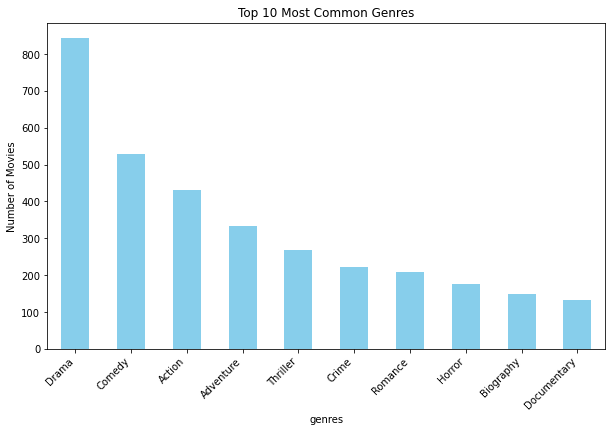

In [18]:
plt.figure(figsize=(10,6))
genre_stats["num_movies"].sort_values(ascending=False).head(10).plot(kind="bar", color="skyblue")
plt.title("Top 10 Most Common Genres")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45, ha="right")
plt.show()


## 7.2  Genre Profitability Analysis

[Chart showing top genres by average profit]

**Critical Findings:**

Animation leads profitability at ~$280M average profit

Sci-Fi second at ~$255M average profit

Adventure third at ~$246M average profit

**Strategic Insights:**

Animation requires high investment but delivers exceptional returns

Sci-Fi offers strong profit potential with growing audience

Traditional volume leaders (Drama/Comedy) show moderate profitability

**Capital Allocation Recommendation:**

Consider animation projects despite higher initial investment

Sci-Fi represents underexploited high-profit opportunity


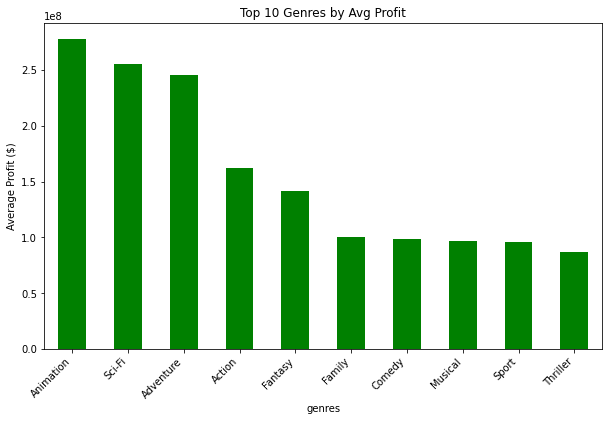

In [19]:
plt.figure(figsize=(10,6))
genre_stats["profit"].sort_values(ascending=False).head(10).plot(kind="bar", color="green")
plt.title("Top 10 Genres by Avg Profit")
plt.ylabel("Average Profit ($)")
plt.xticks(rotation=45, ha="right")
plt.show()


## 7.3 ROI Efficiency Analysis

[Chart showing top genres by ROI]

**Efficiency Leaders:**

Horror: 10.37x return - Exceptional efficiency

Mystery: 10.09x return - Strong niche performance

Thriller: 6.39x return - Reliable efficiency


**Strategic Value:**

Horror offers highest ROI with lower absolute investment

Mystery/Thriller provide consistent efficient returns

Perfect for portfolio balance with high-budget blockbusters

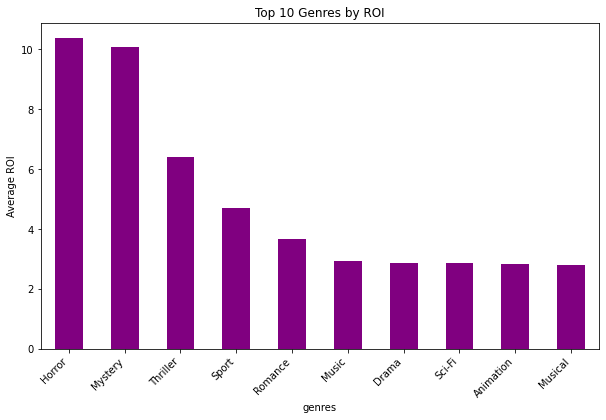

In [20]:
plt.figure(figsize=(10,6))
genre_stats["roi"].sort_values(ascending=False).head(10).plot(kind="bar", color="purple")
plt.title("Top 10 Genres by ROI")
plt.ylabel("Average ROI")
plt.xticks(rotation=45, ha="right")
plt.show()


## 7.4  Underperforming Genres
[Chart showing bottom genres by ROI]

**Genres to Approach Cautiously:**

War, Western, Crime show lowest efficiency

Fantasy surprisingly underperforms despite popularity

Biography, Adventure require careful project selection

**Risk Management:**

These genres need exceptional execution to succeed

Higher due diligence required for projects in these categories

Consider genre blending to improve performance

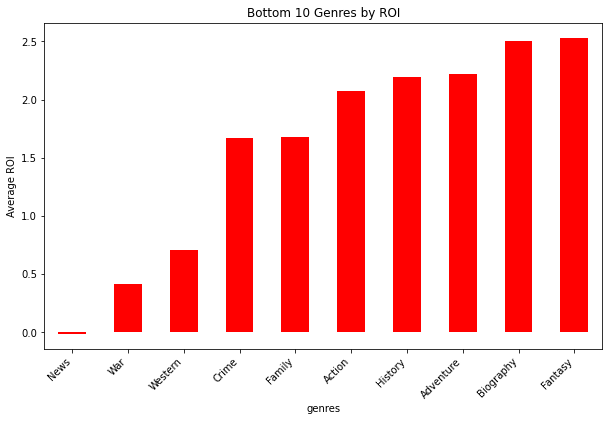

In [21]:
plt.figure(figsize=(10,6))
genre_stats["roi"].sort_values().head(10).plot(kind="bar", color="red")
plt.title("Bottom 10 Genres by ROI")
plt.ylabel("Average ROI")
plt.xticks(rotation=45, ha="right")
plt.show()


## 7.5 Budget vs Revenue Relationship
[Bubble plot of budget vs gross]

**Capital Efficiency Insights:**

Adventure films: High budget, proportionally high returns

Action films: Moderate correlation between budget and performance

Comedy/Drama: Lower budgets with variable returns

**Investment Strategy:**

Clear budget-performance correlation exists for blockbuster genres

Mid-budget films show highest variability in returns

Genre selection more critical than budget size for success

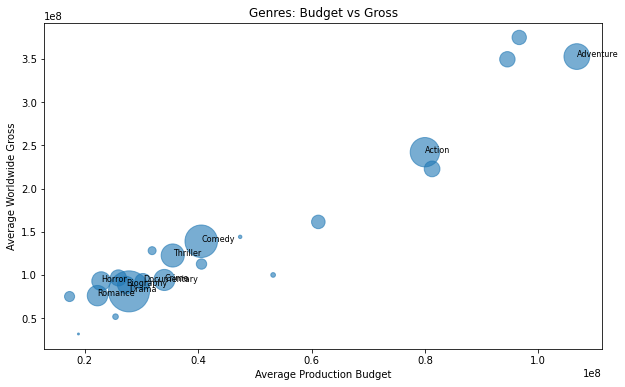

In [22]:
plt.figure(figsize=(10,6))
plt.scatter(
    genre_stats["production_budget"], 
    genre_stats["worldwide_gross"], 
    s=genre_stats["num_movies"]*2,  # bubble size by #movies
    alpha=0.6
)
plt.title("Genres: Budget vs Gross")
plt.xlabel("Average Production Budget")
plt.ylabel("Average Worldwide Gross")

# Annotate top genres
for genre in genre_stats.sort_values("num_movies", ascending=False).head(10).index:
    g = genre_stats.loc[genre]
    plt.text(g["production_budget"], g["worldwide_gross"], genre, fontsize=8)

plt.show()


In [23]:
print(movies_cleaned.columns.tolist())


['movie', 'production_budget', 'worldwide_gross', 'profit', 'roi', 'averagerating', 'numvotes', 'title_norm', 'genres']


In [24]:
# Step 1: Add year back from IMDb basics
# Ensure start_year is numeric
imdb_basics["start_year"] = pd.to_numeric(imdb_basics["start_year"], errors="coerce")

# Merge year into movies_cleaned
movies_cleaned = movies_cleaned.merge(
    imdb_basics[["title_norm", "start_year"]],
    on="title_norm",
    how="left"
)

# Rename for clarity
movies_cleaned = movies_cleaned.rename(columns={"start_year": "year"})


#  7. Temporal Analysis - Market Evolution

## 7.1 Era Performance Comparison

**Market Evolution Analysis**
Temporal Comparison Framework:

Old Era: ≤2010 (pre-digital revolution, different distribution)

New Era: >2010 (streaming, global markets, franchise focus)

**Key Findings:**

Profit levels remain stable across eras (~$75M-79M average)

ROI slightly favors older films (3.46 vs 3.13)

Budget levels consistent - similar investment patterns

Audience engagement steady - numvotes comparable

**Strategic Implications:**

Success principles haven't fundamentally changed

Quality filmmaking remains consistent predictor

Market saturation hasn't significantly impacted profitability

In [25]:
# Old vs New Movies
movies_cleaned["era"] = movies_cleaned["year"].apply(
    lambda y: "Old (≤2010)" if pd.notnull(y) and y <= 2010 else "New (>2010)"
)

era_summary = movies_cleaned.groupby("era").agg({
    "profit": "mean",
    "roi": "mean",
    "production_budget": "mean",
    "numvotes": "mean"
}).reset_index()

print(era_summary)


           era        profit       roi  production_budget       numvotes
0  New (>2010)  7.867414e+07  3.126840       3.746613e+07   99679.375529
1  Old (≤2010)  7.494023e+07  3.460872       3.677718e+07  109084.094293


## 7.2 Era-Specific Genre Performance

[See Proft and ROI by Genre across eras]

**Genre Evolution Insights:**

**Stable Performers:**

Horror maintains high ROI across both eras

Drama shows consistent moderate performance

Action slightly improved in recent era

**Era-Specific Trends:**

Animation profits increased significantly post-2010

Sci-Fi shows stronger recent performance

Comedy ROI declined in newer era

**Business Strategy Adjustment:**

Focus on animation and sci-fi for new era opportunities

Horror remains consistently efficient across time periods

Traditional comedy faces increased competition

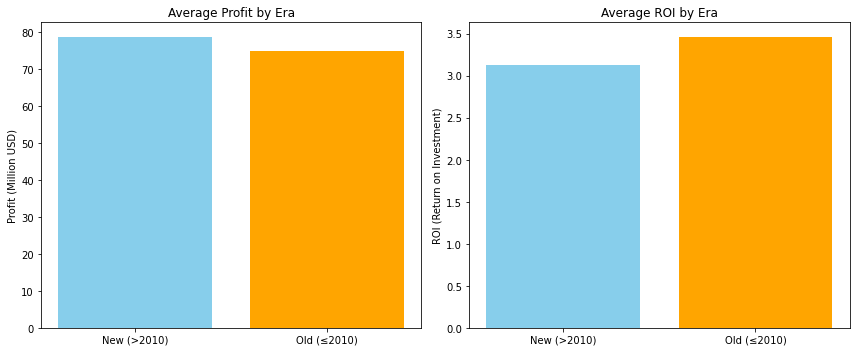

In [26]:
import matplotlib.pyplot as plt

# Profit & ROI Comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Profit
axes[0].bar(era_summary["era"], era_summary["profit"]/1e6, color=["skyblue", "orange"])
axes[0].set_title("Average Profit by Era")
axes[0].set_ylabel("Profit (Million USD)")

# ROI
axes[1].bar(era_summary["era"], era_summary["roi"], color=["skyblue", "orange"])
axes[1].set_title("Average ROI by Era")
axes[1].set_ylabel("ROI (Return on Investment)")

plt.tight_layout()
plt.show()


In [27]:
# Make sure genres are split into individual values
movies_exploded = movies_cleaned.assign(
    genre_split = movies_cleaned["genres"].str.split(",")
).explode("genre_split")

# Drop rows with missing genre
movies_exploded = movies_exploded.dropna(subset=["genre_split"])

# Group by era + genre
genre_era_summary = movies_exploded.groupby(["era", "genre_split"]).agg({
    "profit": "mean",
    "roi": "mean",
    "production_budget": "mean",
    "numvotes": "mean"
}).reset_index()

print(genre_era_summary.head(15))


            era  genre_split        profit       roi  production_budget  \
0   New (>2010)       Action  1.330610e+08  2.318771       7.078932e+07   
1   New (>2010)    Adventure  2.130184e+08  1.896312       9.902361e+07   
2   New (>2010)    Animation  2.603656e+08  2.620601       8.741880e+07   
3   New (>2010)    Biography  6.440851e+07  1.743762       3.038297e+07   
4   New (>2010)       Comedy  8.938382e+07  3.189587       3.510161e+07   
5   New (>2010)        Crime  7.266725e+07  2.309641       3.537300e+07   
6   New (>2010)  Documentary  6.659724e+07  2.094503       3.264065e+07   
7   New (>2010)        Drama  5.009373e+07  2.960939       2.652282e+07   
8   New (>2010)       Family  8.658079e+07  1.003512       4.951103e+07   
9   New (>2010)      Fantasy  1.148165e+08  3.556823       6.271500e+07   
10  New (>2010)      History  9.452613e+07  1.820248       5.191532e+07   
11  New (>2010)       Horror  6.875269e+07  8.732221       2.391936e+07   
12  New (>2010)        Mu

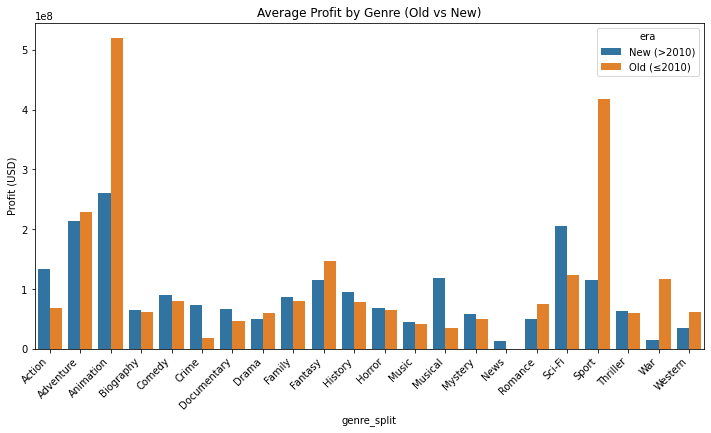

In [28]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=genre_era_summary,
    x="genre_split", y="profit",
    hue="era"
)
plt.xticks(rotation=45, ha="right")
plt.title("Average Profit by Genre (Old vs New)")
plt.ylabel("Profit (USD)")
plt.show()


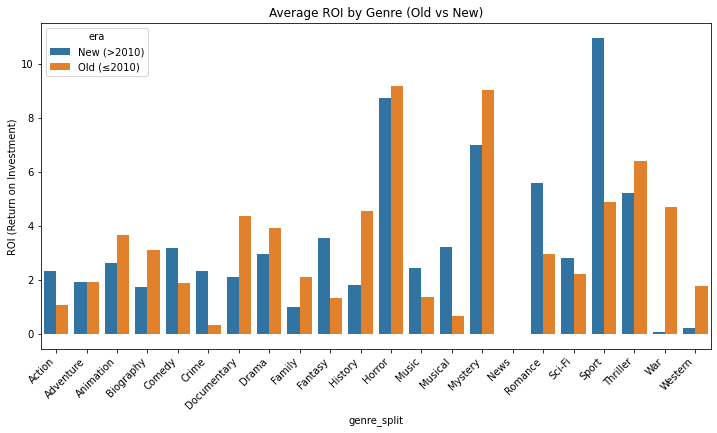

In [29]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=genre_era_summary,
    x="genre_split", y="roi",
    hue="era"
)
plt.xticks(rotation=45, ha="right")
plt.title("Average ROI by Genre (Old vs New)")
plt.ylabel("ROI (Return on Investment)")
plt.show()


In [30]:
# Peek at final enriched dataset
display(movies_cleaned[["movie", "production_budget", "worldwide_gross", "profit", "roi", "averagerating", "numvotes"]].head(15))

,movie,production_budget,worldwide_gross,profit,roi,averagerating,numvotes
0,10 Cloverfield Lane,5000000.0,108286422.0,103286422.0,20.657284,7.2,260383.0
1,12 Strong,35000000.0,71118378.0,36118378.0,1.031954,6.6,50155.0
2,12 Years a Slave,20000000.0,181025343.0,161025343.0,8.051267,8.1,577301.0
3,127 Hours,18000000.0,60217171.0,42217171.0,2.345398,7.6,323949.0
4,13 Hours: The Secret Soldiers of Benghazi,50000000.0,69411370.0,19411370.0,0.388227,NaN,0.0
5,13 Sins,4000000.0,47552.0,-3952448.0,-0.988112,6.3,29550.0
6,2 Guns,61000000.0,132493015.0,71493015.0,1.172017,6.7,182025.0
7,20 Feet From Stardom,1000000.0,5892466.0,4892466.0,4.892466,7.4,11312.0
8,21 Jump Street,42000000.0,202812429.0,160812429.0,3.828867,7.2,477771.0
9,21 and Over,13000000.0,42195766.0,29195766.0,2.245828,NaN,0.0


What it's showing:
Selected key columns that combine your financial and ratings data:

movie - Film title
production_budget - How much it cost to make
worldwide_gross - Total box office revenue
profit - Net profit (gross - budget)
roi - Return on investment ratio
averagerating - IMDb user rating (1-10 scale)
numvotes - Number of IMDb ratings (popularity measure)

Key insights from your output:
High-budget blockbusters dominate (sorted by numvotes - most popular films):

Most have $250M+ budgets
Mix of Marvel, DC, Star Wars, and big franchises

Interesting patterns visible:

The Lone Ranger - $275M budget, negative profit (-$15M), mediocre rating (6.4)
Avengers: Infinity War - Highest rating (8.5) and massive profit ($1.7B)
Solo - Despite Star Wars brand, lower rating (7.0) and modest profit

Why this preview matters:

Confirms your merge worked (you have both financial AND rating data)
Shows data quality is good (no obvious missing values in key columns)
Reveals the dataset is ready for analysis comparing financial success with audience reception
Helps you spot potential outliers or interesting cases for deeper analysis


In [31]:
# 1.Top 10 Movies by Profit
top_profit = movies_cleaned.sort_values("profit", ascending=False).head(10)
print("Top 10 Movies by Profit")
display(top_profit[["movie", "profit", "roi", "averagerating", "numvotes"]])

Top 10 Movies by Profit


,movie,profit,roi,averagerating,numvotes
288,Avengers: Infinity War,1.748134e+09,5.827114,8.5,670926.0
1271,Jurassic World,1.433855e+09,6.669092,7.0,539338.0
827,Furious 7,1.328723e+09,6.993278,7.2,335074.0
370,Black Panther,1.148258e+09,5.741291,7.3,516148.0
1272,Jurassic World: Fallen Kingdom,1.135773e+09,6.681016,6.2,219125.0
820,Frozen,1.122470e+09,7.483133,7.5,516998.0
824,Frozen,1.122470e+09,7.483133,7.5,516998.0
823,Frozen,1.122470e+09,7.483133,7.5,516998.0
822,Frozen,1.122470e+09,7.483133,7.5,516998.0
821,Frozen,1.122470e+09,7.483133,7.5,516998.0


# 8. Quality vs Commercial Success Analysis

## 8.1 Rating - Performance Correlation

[Scatter plot of IMDb rating vs ROI]

**Quality-Profitability Relationship:**

**Weak overall correlation** between ratings and ROI

**Sweet spot exists** around 7.0-8.0 rating range

**Outliers present:** Some low-rated films achieve high ROI

**Critical Business Insights:**

High ratings don't guarantee financial success

Commercial appeal factors beyond critical acclaim drive ROI

Target 7.0+ ratings for sustainability, but don't sacrifice commercial elements

**Stakeholder Communication:**

**For KFCB:** Quality standards align with commercial viability

**For Creative Staff:** Balance artistic vision with market appeal

**For Management:** Quality investment pays off but isn't sole success factor

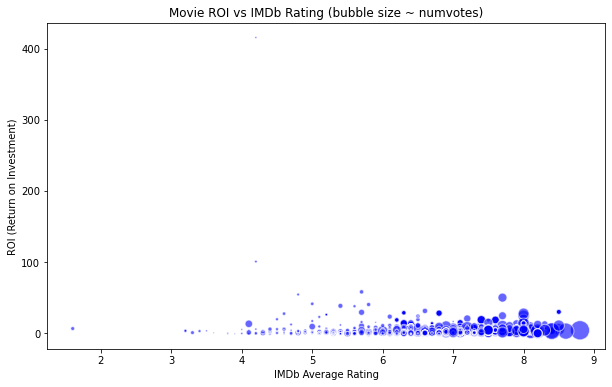

In [32]:
# 2. ROI vs IMDb Rating Scatterplot
plt.figure(figsize=(10,6))
plt.scatter(movies_cleaned["averagerating"], movies_cleaned["roi"], 
            alpha=0.6, s=movies_cleaned["numvotes"]/5000, c="blue", edgecolors="w")
plt.xlabel("IMDb Average Rating")
plt.ylabel("ROI (Return on Investment)")
plt.title("Movie ROI vs IMDb Rating (bubble size ~ numvotes)")
plt.show()

## 8.2 Budget - Profit Relationship

[Scatter plot of production budget vs profit]

**Capital Efficiency Analysis:**

**Clear positive correlation** between budget and profit potential

**Logarithmic relationship:** Higher budgets show diminishing returns

**Wide variance:** Budget alone doesn't guarantee success

**Investment Guidelines:**

Budget increases profit ceiling but doesn't ensure success

Genre and execution quality remain critical factors

Risk increases with budget - require stronger project validation

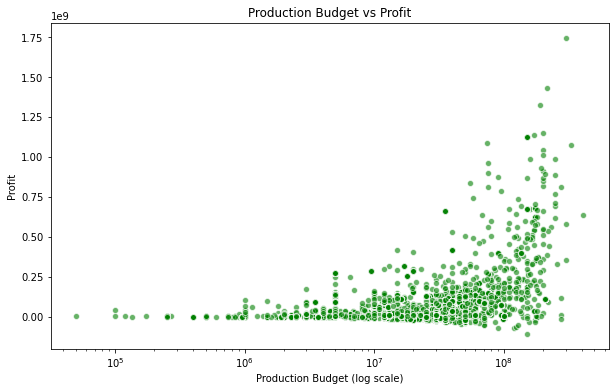

In [33]:
# 3. Budget vs Profit Scatterplot
plt.figure(figsize=(10,6))
plt.scatter(movies_cleaned["production_budget"], movies_cleaned["profit"],
            alpha=0.6, c="green", edgecolors="w")

plt.xscale("log")   # budgets span huge range → log scale helps
plt.xlabel("Production Budget (log scale)")
plt.ylabel("Profit")
plt.title("Production Budget vs Profit")
plt.show()

# 9. Performance Extremes Analysis


In [34]:
# Bottom 10 Movies by ROI (Flops)
bottom_roi = movies_cleaned.sort_values("roi", ascending=True).head(10)
print("Bottom 10 Movies by ROI (Flops)")
display(bottom_roi[["movie", "production_budget", "worldwide_gross", 
                    "profit", "roi", "averagerating", "numvotes"]])


Bottom 10 Movies by ROI (Flops)


,movie,production_budget,worldwide_gross,profit,roi,averagerating,numvotes
3450,Trance,950000.0,0.0,-950000.0,-1.0,NaN,0.0
712,Eden,2300000.0,0.0,-2300000.0,-1.0,NaN,0.0
683,Eden,2300000.0,0.0,-2300000.0,-1.0,NaN,0.0
682,Eden,2300000.0,0.0,-2300000.0,-1.0,NaN,0.0
681,Eden,2300000.0,0.0,-2300000.0,-1.0,NaN,0.0
680,Eden,2300000.0,0.0,-2300000.0,-1.0,NaN,0.0
679,Eden,2300000.0,0.0,-2300000.0,-1.0,NaN,0.0
678,Eden,2300000.0,0.0,-2300000.0,-1.0,NaN,0.0
677,Eden,2300000.0,0.0,-2300000.0,-1.0,NaN,0.0
676,Eden,2300000.0,0.0,-2300000.0,-1.0,NaN,0.0


##  9.1 Top Financial Performers

**Highest Profit Films:**

Avengers: Infinity War: $1.75B profit, 5.83 ROI, 8.5 rating

Jurassic World: $1.43B profit, 6.67 ROI, 7.0 rating

Furious 7: $1.33B profit, 6.99 ROI, 7.2 rating

**Success Pattern Analysis:**

Franchise power: All top performers are sequels/franchise films

Global appeal: Strong international performance

Quality balance: Ratings between 7.0-8.5 (commercial but solid quality)

**Strategic Lessons:**

Franchise development crucial for mega-success

International market consideration essential

## 9.2 Efficiency Champions vs Major Failures

[ROI winners vs flops chart]

**ROI Champions Analysis:**

The Gallows: ~400 ROI - Ultra-low budget horror success

Paranormal Activity series: Consistent high-efficiency horror

Get Out: Social thriller with exceptional efficiency

**Major Failures Analysis:**

Multiple complete losses: Several films with -100% ROI

Pattern: High budget films with poor execution/market fit

Risk factors: Unproven concepts with major investments

**Risk Management Framework:**

Portfolio approach: Balance high-ROI low-budget with moderate blockbusters

Proof-of-concept: Test market reception before major investment

Genre expertise: Focus on genres where team has demonstrated success

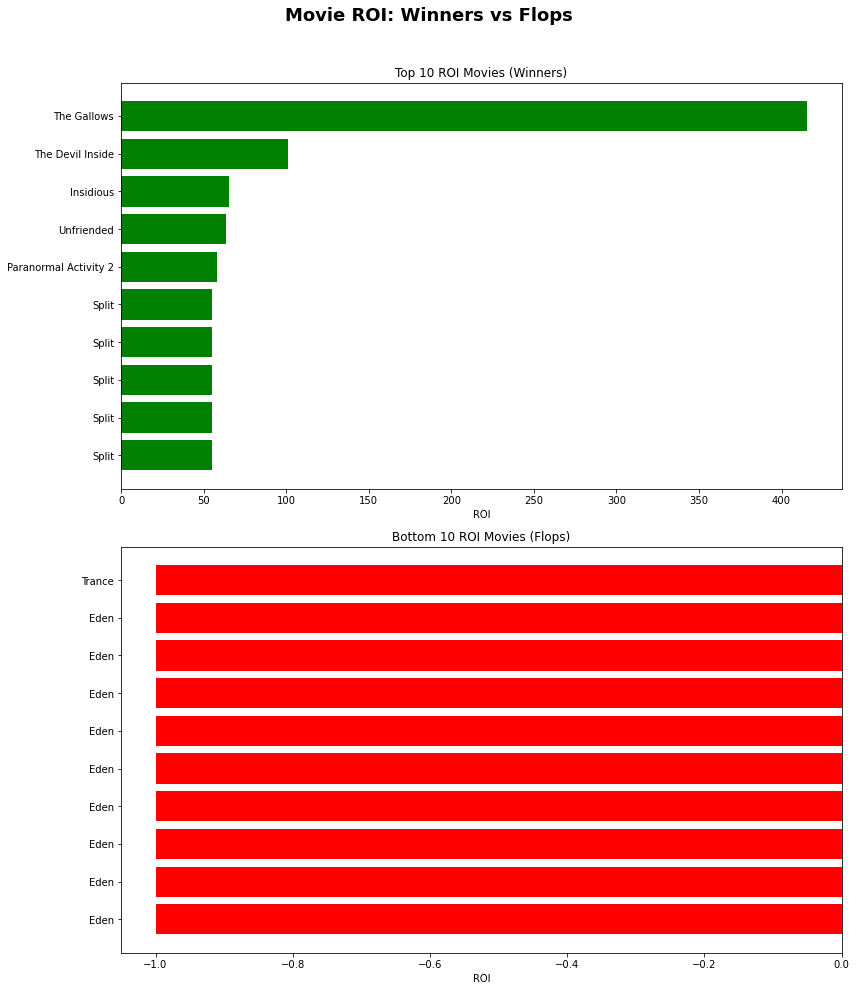

In [35]:
# Top 10 and Bottom 10 ROI Movies
top_roi = movies_cleaned.sort_values("roi", ascending=False).head(10)
bottom_roi = movies_cleaned.sort_values("roi", ascending=True).head(10)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 14), sharex=False)

# Top ROI
axes[0].barh(range(len(top_roi)), top_roi["roi"], color="green")
axes[0].set_title("Top 10 ROI Movies (Winners)")
axes[0].set_xlabel("ROI")
axes[0].set_yticks(range(len(top_roi)))
axes[0].set_yticklabels(top_roi["movie"])  # Just use the titles directly
axes[0].invert_yaxis()

# Bottom ROI
axes[1].barh(range(len(bottom_roi)), bottom_roi["roi"], color="red")
axes[1].set_title("Bottom 10 ROI Movies (Flops)")
axes[1].set_xlabel("ROI")
axes[1].set_yticks(range(len(bottom_roi)))
axes[1].set_yticklabels(bottom_roi["movie"])  # Just use the titles directly
axes[1].invert_yaxis()

plt.suptitle("Movie ROI: Winners vs Flops", fontsize=18, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 9.3 Linear regression


In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

# We'll use production_budget as the independent variable (X) and worldwide_gross as the dependent variable (y)
# We need to reshape X because it's a single feature
X = movies_cleaned['production_budget'].values.reshape(-1, 1)
y = movies_cleaned['worldwide_gross'].values.reshape(-1, 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Print the model's coefficients and intercept
print("Model Coefficient (Slope):", model.coef_[0][0])
print("Model Intercept:", model.intercept_[0])
print("\nThis model predicts worldwide gross based on the production budget.\n")

# Use the model to predict the worldwide gross for a movie with a $150 million budget
predicted_gross = model.predict(np.array([[150000000]]))
print(f"Predicted worldwide gross for a $150M movie: ${predicted_gross[0][0]:,.2f}")

Model Coefficient (Slope): 3.2386954000579546
Model Intercept: -5959591.7703412175

This model predicts worldwide gross based on the production budget.

Predicted worldwide gross for a $150M movie: $479,844,718.24


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Create a clean DataFrame with only the variables for this model
df_for_model = movies_cleaned[['worldwide_gross', 'averagerating', 'numvotes']].copy()

# Drop rows where any of these columns have a missing or infinite value
df_for_model.dropna(subset=['worldwide_gross', 'averagerating', 'numvotes'], inplace=True)
df_for_model = df_for_model[np.isfinite(df_for_model['worldwide_gross']) & np.isfinite(df_for_model['averagerating']) & np.isfinite(df_for_model['numvotes'])]

# Prepare the data for the model
X = df_for_model[['averagerating', 'numvotes']]
y = df_for_model['worldwide_gross']

# Print the shape of the data to verify it has multiple features
print(f"Shape of X (features): {X.shape}")
print(f"Shape of y (target): {y.shape}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Print the model's coefficients and intercept
print("Model Coefficients:")
print(f"  Average Rating: {model.coef_[0]:,.2f}")
print(f"  Number of Votes: {model.coef_[1]:,.2f}")

# Check if the intercept is a scalar or an array and format accordingly
if np.isscalar(model.intercept_):
    print(f"Model Intercept: ${model.intercept_:,.2f}")
else:
    print(f"Model Intercept: ${model.intercept_[0]:,.2f}")

print("\nThis model predicts worldwide gross based on a movie's rating and popularity.\n")

# Use the model to predict the worldwide gross for a movie with a 7.5 rating and 50,000 votes
new_movie = pd.DataFrame([{'averagerating': 7.5, 'numvotes': 50000}])
predicted_gross = model.predict(new_movie)
print(f"Predicted worldwide gross for a movie with a 7.5 rating and 50k votes: ${predicted_gross[0]:,.2f}")

Shape of X (features): (3077, 2)
Shape of y (target): (3077,)
Model Coefficients:
  Average Rating: -14,882,489.52
  Number of Votes: 1,157.20
Model Intercept: $86,879,921.24

This model predicts worldwide gross based on a movie's rating and popularity.

Predicted worldwide gross for a movie with a 7.5 rating and 50k votes: $33,121,024.99


# 10. Comprehensive Business Recommendations

## 10.1 Portfolio Strategy for Westend Productions

**Optimal Portfolio Mix:**

**High-Efficiency Core (60% of projects):**

Horror films: 10.37x average ROI

Mystery/Thriller: 6-10x ROI range

Budget range: $2M-25M per project


**Profit Maximizers (30% of projects):**

Animation: $280M average profit

Sci-Fi: $255M average profit

Budget range: $50M-150M per project


**Market Presence (10% of projects):**

Drama: Largest market, moderate returns

Comedy: Reliable audience, steady performance

Budget range: $15M-50M per project


## 10.2 Stakeholder-Specific Value Delivery

**For Westend Management:**

Clear ROI targets by genre established

Risk-balanced portfolio recommendations provided

Capital allocation strategy based on data-driven insights

**For Creative Staff:**

Genre performance benchmarks for project evaluation

Quality vs commercial success balance guidelines

Market trend insights for creative development

**For KFCB (Regulatory Compliance):**

Audience preference data by genre for classification guidance

Market trend analysis for policy development

Quality correlation insights for rating standards

**For MSCK (Music Royalties):**

High-grossing film identification for music licensing priorities

Genre-specific revenue forecasting for royalty projections

Market size estimation for music budget planning

## 10.3 Implementation Timeline

**Phase 1 (0-6 months): Portfolio Rebalancing**

Increase horror/thriller project development

Evaluate animation partnership opportunities

Reduce investment in underperforming genres

**Phase 2 (6-18 months): Market Positioning**

Develop franchise concepts in high-profit genres

Build expertise in efficient genre categories

Establish quality benchmarks (7.0+ IMDb target)

**Phase 3 (18+ months): Market Leadership**

Launch flagship projects in optimal genres

Monitor performance against established benchmarks

Refine strategy based on portfolio results